In [1]:
import logging; logging.basicConfig(level=logging.INFO)
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import logictensornetworks as ltn

# Data

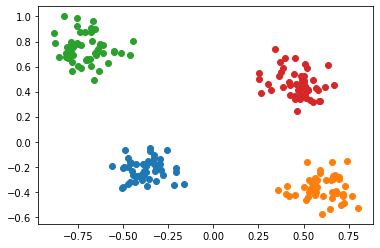

In [2]:
# loading data

nr_of_clusters = 4
nr_of_points_x_cluster = 50
clst_ids = range(nr_of_clusters)

margin = .2
mean = [np.random.uniform([-1+margin,-1+margin],[0-margin,0-margin],2),
       np.random.uniform([0+margin,-1+margin],[1-margin,0-margin],2),
       np.random.uniform([-1+margin,0+margin],[0-margin,1-margin],2),
       np.random.uniform([0+margin,0+margin],[1-margin,1-margin],2)]

cov = np.array([[[.01,0],[0,.01]]]*nr_of_clusters)

cluster_data = {}
for i in clst_ids:
    cluster_data[i] = np.random.multivariate_normal(mean=mean[i],cov=cov[i],size=nr_of_points_x_cluster)

data  = np.concatenate([cluster_data[i] for i in clst_ids])
closed_data = np.array([np.concatenate([data[i],data[j]])
                             for i in range(len(data))
                             for j in range(i,len(data))
                             if np.sum(np.square(data[i]-data[j])) < 0.2])
distant_data = np.array([np.concatenate([data[i],data[j]])
                             for i in range(len(data))
                             for j in range(len(data))
                             if np.sum(np.square(data[i]-data[j])) > 1.])
for i in clst_ids:
    plt.scatter(cluster_data[i][:, 0], cluster_data[i][:, 1])

# Language

In [3]:
Not = ltn.Wrapper_Connective(ltn.fuzzy_ops.Not_Std())
And = ltn.Wrapper_Connective(ltn.fuzzy_ops.And_Prod())
Or = ltn.Wrapper_Connective(ltn.fuzzy_ops.Or_ProbSum())
Implies = ltn.Wrapper_Connective(ltn.fuzzy_ops.Implies_Reichenbach())
Equiv = ltn.Wrapper_Connective(ltn.fuzzy_ops.Equiv(ltn.fuzzy_ops.And_Prod(),ltn.fuzzy_ops.Implies_Reichenbach()))
Forall = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMeanError(p=4),semantics="forall")
Exists = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMean(p=6),semantics="exists")

In [4]:
from tensorflow.keras import layers

class MLP_classifier(tf.keras.Model):
    """ Model to call as P(x,class) """
    def __init__(self, n_classes, single_label, hidden_layer_sizes=(16,16,16)):
        super(MLP_classifier, self).__init__()
        self.denses = [layers.Dense(s, activation="elu") for s in hidden_layer_sizes]
        self.dense_class = layers.Dense(n_classes)
        self.to_probs = tf.nn.softmax if single_label else tf.math.sigmoid
        
    def call(self, inputs):
        x, c = inputs[0], inputs[1]
        for dense in self.denses:
            x = dense(x)
        logits = self.dense_class(x)
        probs = self.to_probs(logits)
        indices = tf.cast(c, tf.int32)
        return tf.gather(probs, indices, batch_dims=1) 

C = ltn.Predicate(MLP_classifier(nr_of_clusters, single_label=True))
cluster = ltn.variable("cluster",clst_ids)

first = ltn.Function.Lambda(lambda x_y: x_y[:,:2])
second = ltn.Function.Lambda(lambda x_y: x_y[:,2:])

x = ltn.variable("x",data)
closed_x_y = ltn.variable("closed_x_y",closed_data)
distant_x_y = ltn.variable("distant_x_y",distant_data)


In [5]:
formula_aggregator = ltn.fuzzy_ops.Aggreg_pMeanError(p=2)

# defining the theory
#@tf.function
def axioms(p_exists):
    axioms = [
        Forall(x, Exists(cluster, C([x,cluster]),p=p_exists)),
        Forall(cluster, Exists(x, C([x,cluster]),p=p_exists)),
        Forall([cluster,closed_x_y], Equiv(C([first(closed_x_y),cluster]),C([second(closed_x_y),cluster]))),
        Forall([cluster,distant_x_y], Not(And(C([first(distant_x_y),cluster]),C([second(distant_x_y),cluster]))))
    ]
    axioms = tf.stack(axioms)
    sat_level = formula_aggregator(axioms)
    return sat_level, axioms


In [6]:
# first call will be long, because constructing the graph
axioms(p_exists=6)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.45382184>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.2690485 , 0.26684988, 0.65824497, 0.93283814], dtype=float32)>)

# Training

In [7]:
trainable_variables = C.trainable_variables
#optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

for epoch in range(1000):
    if epoch <= 100:
        p_exists = 1
    else:
        p_exists = 6
    with tf.GradientTape() as tape:
        loss_value = 1. - axioms(p_exists=p_exists)[0]
    grads = tape.gradient(loss_value, trainable_variables)
    optimizer.apply_gradients(zip(grads, trainable_variables))
    if epoch%100 == 0:
        print("Epoch %d: Sat Level %.3f"%(epoch, axioms(p_exists=p_exists)[0]))
print("Training finished at Epoch %d with Sat Level %.3f"%(epoch, axioms(p_exists=p_exists)[0]))

Epoch 0: Sat Level 0.442
Epoch 100: Sat Level 0.442
Epoch 200: Sat Level 0.675
Epoch 300: Sat Level 0.843
Epoch 400: Sat Level 0.845
Epoch 500: Sat Level 0.846
Epoch 600: Sat Level 0.846
Epoch 700: Sat Level 0.846
Epoch 800: Sat Level 0.847
Epoch 900: Sat Level 0.847
Training finished at Epoch 999 with Sat Level 0.847


## Show result

In [8]:
plt.rcParams['font.size'] = 12


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



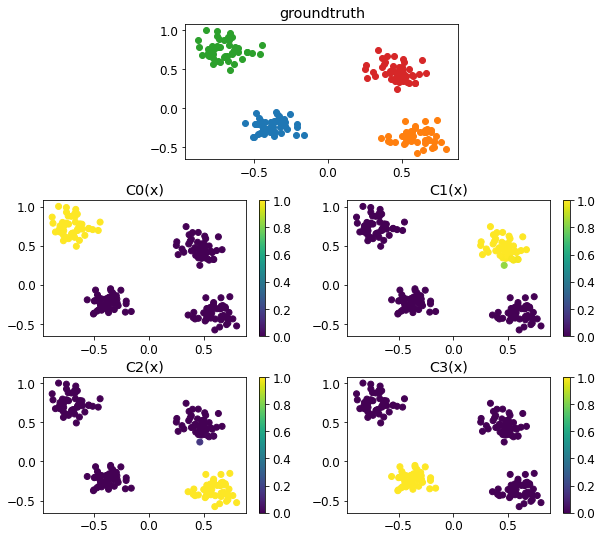

In [9]:
x0 = data[:, 0]
x1 = data[:, 1]

prC = [C.model([data, tf.constant([[i]]*len(data))]) for i in clst_ids]
n = 2
m = (nr_of_clusters + 1) // n + 1

fig = plt.figure(figsize=(10, m * 3))

plt.subplots_adjust(wspace=0.2,hspace=0.3)
ax = plt.subplot2grid((m,8),(0,2),colspan=4)
ax.set_title("groundtruth")
for i in clst_ids:
    ax.scatter(cluster_data[i][:, 0], cluster_data[i][:, 1])
for i in clst_ids:
    fig.add_subplot(m, n, i + 3)
    plt.title("C" + str(i) + "(x)")
    plt.scatter(x0, x1, c=prC[i],vmin=0,vmax=1)
    plt.colorbar()
# plt.savefig("ex_clustering_test.pdf")
plt.show()